# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>
#include <cmath>

// Use (void) to silent unused warnings.
#define assertm(exp, msg) assert(((void)msg, exp))

In [2]:
#define VAR_NAME(Variable) (#Variable)

void print_tensor_size(std::string name, torch::Tensor t)
{
    int dims = t.dim();
    std::cout << name << " dims is (";
    for (int i = 0; i < dims; i++) {
        std::cout << t.size(i);
        if (i < (dims - 1)) std::cout << " x ";
    }
    std::cout << ")" << std::endl;
}

# Dropout

### 我们实现 dropout_layer 函数，该函数以dropout的概率丢弃张量输入X中的元素

In [3]:
torch::Tensor dropout_layer(torch::Tensor X, float dropout, bool is_training = false)
{
    if (!is_training) {
        return X;
    }
    
    assert(dropout >= 0.0 && dropout <= 1.0);
    if (dropout == 1) {
        return torch::zeros_like(X);
    } else if (dropout == 0) {
        return X;
    } else {
//         torch::Tensor mask_ = torch::randn({X.size(0), X.size(1)});
//         mask_.index_put_({mask_ > dropout}, 0);
//         return mask_;
        torch::Tensor mask_ = (torch::randn({X.size(0), X.size(1)}) > dropout).to(torch::kFloat);         
        return mask_ * X;
    }
}

### 测试dropout_layer函数

In [4]:
torch::Tensor X = torch::arange(16).reshape({2, 8});
printT(X)
printT(dropout_layer(X, 0.0, true));
printT(dropout_layer(X, 1.0, true));
printT(dropout_layer(X, 0.9, true));

X = 
  0   1   2   3   4   5   6   7
  8   9  10  11  12  13  14  15
[ CPULongType{2,8} ]
<<--->>

dropout_layer(X, 0.0, true) = 
  0   1   2   3   4   5   6   7
  8   9  10  11  12  13  14  15
[ CPULongType{2,8} ]
<<--->>

dropout_layer(X, 1.0, true) = 
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
[ CPULongType{2,8} ]
<<--->>

dropout_layer(X, 0.9, true) = 
  0   0   0   0   0   0   6   0
  8   9   0   0  12   0  14   0
[ CPUFloatType{2,8} ]
<<--->>



### 简洁实现

In [5]:
// Define a new Module.
struct Net : torch::nn::Module {
  Net() {
    // Construct and register two Linear submodules.
    fc1 = register_module("fc1", torch::nn::Linear(784, 64));
    fc2 = register_module("fc2", torch::nn::Linear(64, 32));
    fc3 = register_module("fc3", torch::nn::Linear(32, 10));
  }

  // Implement the Net's algorithm.
  torch::Tensor forward(torch::Tensor x) {
    // Use one of many tensor manipulation functions.
    x = torch::relu(fc1->forward(x.reshape({x.size(0), 784})));
    x = torch::dropout(x, /*p=*/0.5, /*train=*/is_training());
    x = torch::relu(fc2->forward(x));

    //此处使用我们自定义的dropout函数
    x = dropout_layer(x, 0.5, is_training());
    //x = torch::dropout(x, /*p=*/0.5, /*train=*/is_training());
    x = torch::log_softmax(fc3->forward(x), 1);
    return x;
  }

  // Use one of many "standard library" modules.
  torch::nn::Linear fc1{nullptr}, fc2{nullptr}, fc3{nullptr};
};

In [6]:
std::vector<int> x;
std::vector<double> y;
std::vector<double> y_hat;

In [7]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

In [8]:
// Create a multi-threaded data loader for the MNIST dataset.
auto data_loader = torch::data::make_data_loader(
                              torch::data::datasets::MNIST("../dataset/mnist").map(
                              torch::data::transforms::Stack<>()),
                              /*batch_size=*/200);

auto test_data_loader = torch::data::make_data_loader(
                              torch::data::datasets::MNIST("../dataset/mnist", torch::data::datasets::MNIST::Mode::kTest).map(
                              torch::data::transforms::Stack<>()),
                              /*batch_size=*/200);

In [9]:
// Create a new Net.
auto net = std::make_shared<Net>();

// Instantiate an SGD optimization algorithm to update our Net's parameters.
torch::optim::SGD optimizer(net->parameters(), /*lr=*/0.01);

for (size_t epoch = 1; epoch <= 100; ++epoch) {
    size_t batch_index = 0;
    x.push_back(epoch);
    
    torch::Tensor train_loss = torch::zeros(1);
    torch::Tensor test_loss = torch::zeros(1);
    // Iterate the data loader to yield batches from the dataset.
    for (auto& batch : *data_loader) {
        // Reset gradients.
        optimizer.zero_grad();
        // Execute the model on the input data.
        torch::Tensor prediction = net->forward(batch.data);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = torch::nll_loss(prediction, batch.target);
        // Compute gradients of the loss w.r.t. the parameters of our model.
        loss.backward();
        // Update the parameters based on the calculated gradients.
        optimizer.step();
        // Output the loss and checkpoint every 100 batches.
        if (++batch_index % 200 == 0) {
        std::cout << "Epoch: " << epoch << " | Batch: " << batch_index
                  << " | Loss: " << loss.item<float>() << std::endl;
        // Serialize your model periodically as a checkpoint.
        //torch::save(net, "net.pt");
        }
    }
    
    y.push_back(train_loss.sum().item<double>());

    for (auto& batch : *test_data_loader) {
        // Execute the model on the input data.
        torch::Tensor prediction = net->forward(batch.data);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = torch::nll_loss(prediction, batch.target);
        test_loss += loss;
    }    
    
    y_hat.push_back(test_loss.sum().item<double>());

}

Epoch: 1 | Batch: 200 | Loss: 2.30999
Epoch: 2 | Batch: 200 | Loss: 2.28852
Epoch: 3 | Batch: 200 | Loss: 2.28472
Epoch: 4 | Batch: 200 | Loss: 2.27238
Epoch: 5 | Batch: 200 | Loss: 2.23207
Epoch: 6 | Batch: 200 | Loss: 2.20623
Epoch: 7 | Batch: 200 | Loss: 2.11551
Epoch: 8 | Batch: 200 | Loss: 2.09057
Epoch: 9 | Batch: 200 | Loss: 1.95605
Epoch: 10 | Batch: 200 | Loss: 1.87999
Epoch: 11 | Batch: 200 | Loss: 1.75484
Epoch: 12 | Batch: 200 | Loss: 1.64457
Epoch: 13 | Batch: 200 | Loss: 1.554
Epoch: 14 | Batch: 200 | Loss: 1.56282
Epoch: 15 | Batch: 200 | Loss: 1.40474
Epoch: 16 | Batch: 200 | Loss: 1.37954
Epoch: 17 | Batch: 200 | Loss: 1.2995
Epoch: 18 | Batch: 200 | Loss: 1.33053
Epoch: 19 | Batch: 200 | Loss: 1.38841
Epoch: 20 | Batch: 200 | Loss: 1.2569
Epoch: 21 | Batch: 200 | Loss: 1.24038
Epoch: 22 | Batch: 200 | Loss: 1.24228
Epoch: 23 | Batch: 200 | Loss: 1.23478
Epoch: 24 | Batch: 200 | Loss: 1.14442
Epoch: 25 | Batch: 200 | Loss: 1.16701
Epoch: 26 | Batch: 200 | Loss: 1.14395

In [10]:
plt::plot(x, y, "b");
plt::plot(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss_3.png"); 
plt::show();

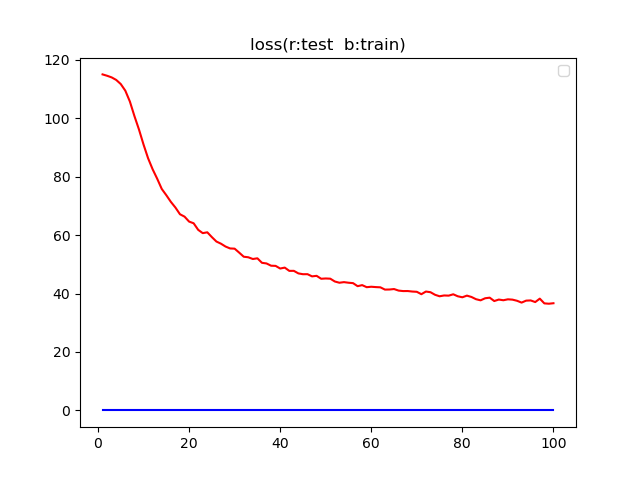

In [11]:
auto img2 = im::image("./loss_3.png");
img2

### 用Sequential实现

In [12]:
torch::nn::Sequential net1({
                       {"flatten", torch::nn::Flatten()},
                       {"fc1", torch::nn::Linear(torch::nn::LinearOptions(784, 256).bias(false))},
                       {"ReLU1", torch::nn::ReLU()},
                       {"Dropout1", torch::nn::Dropout(0.2)},
                       {"fc2", torch::nn::Linear(torch::nn::LinearOptions(256, 256).bias(false))},
                       {"ReLU2", torch::nn::ReLU()},
                       {"Dropout2", torch::nn::Dropout(0.5)},
                       {"fc3", torch::nn::Linear(torch::nn::LinearOptions(256, 10).bias(false))},
                           });

net1->push_back(torch::nn::Functional(torch::nn::functional::log_softmax, 1));

net1->to(torch::kCUDA);

In [13]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

In [14]:
// Instantiate an SGD optimization algorithm to update our Net's parameters.
torch::optim::SGD optimizer1(net1->parameters(), /*lr=*/0.01);

for (size_t epoch = 1; epoch <= 100; ++epoch) {
    size_t batch_index = 0;
    x.push_back(epoch);
    
    torch::Tensor train_loss = torch::zeros(1);
    torch::Tensor test_loss = torch::zeros(1);
    // Iterate the data loader to yield batches from the dataset.
    for (auto& batch : *data_loader) {
        torch::Tensor real_images = batch.data.to(torch::kCUDA);
        torch::Tensor real_labels = batch.target.to(torch::kCUDA);
        // Reset gradients.
        optimizer1.zero_grad();
        // Execute the model on the input data.
        torch::Tensor prediction = net1->forward(real_images);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = torch::nll_loss(prediction, real_labels);
//         print_tensor_size("prediction", prediction);
//         print_tensor_size("batch.target", batch.target);
        auto loss_cpu = loss.to(torch::kCPU);
        train_loss += loss_cpu;
        // Compute gradients of the loss w.r.t. the parameters of our model.
        loss.backward();
        // Update the parameters based on the calculated gradients.
        optimizer1.step();
        // Output the loss and checkpoint every 100 batches.
        if (++batch_index % 200 == 0) {
        std::cout << "Epoch: " << epoch << " | Batch: " << batch_index
                  << " | Loss: " << loss_cpu.item<float>() << std::endl;
        // Serialize your model periodically as a checkpoint.
        //torch::save(net, "net.pt");
        }
    }
    
    y.push_back(train_loss.sum().item<double>());

    for (auto& batch : *test_data_loader) {
        torch::Tensor real_images = batch.data.to(torch::kCUDA);
        torch::Tensor real_labels = batch.target.to(torch::kCUDA);
        
        // Execute the model on the input data.
        torch::Tensor prediction = net1->forward(real_images);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = torch::nll_loss(prediction, real_labels);
        test_loss += loss.to(torch::kCPU);
    }    
    
    y_hat.push_back(test_loss.sum().item<double>());

}

Epoch: 1 | Batch: 200 | Loss: 2.24104
Epoch: 2 | Batch: 200 | Loss: 1.88267
Epoch: 3 | Batch: 200 | Loss: 1.14053
Epoch: 4 | Batch: 200 | Loss: 0.823152
Epoch: 5 | Batch: 200 | Loss: 0.729519
Epoch: 6 | Batch: 200 | Loss: 0.594967
Epoch: 7 | Batch: 200 | Loss: 0.665473
Epoch: 8 | Batch: 200 | Loss: 0.640772
Epoch: 9 | Batch: 200 | Loss: 0.554107
Epoch: 10 | Batch: 200 | Loss: 0.526012
Epoch: 11 | Batch: 200 | Loss: 0.484894
Epoch: 12 | Batch: 200 | Loss: 0.367845
Epoch: 13 | Batch: 200 | Loss: 0.38559
Epoch: 14 | Batch: 200 | Loss: 0.39391
Epoch: 15 | Batch: 200 | Loss: 0.313823
Epoch: 16 | Batch: 200 | Loss: 0.331523
Epoch: 17 | Batch: 200 | Loss: 0.256289
Epoch: 18 | Batch: 200 | Loss: 0.248579
Epoch: 19 | Batch: 200 | Loss: 0.352759
Epoch: 20 | Batch: 200 | Loss: 0.3274
Epoch: 21 | Batch: 200 | Loss: 0.279968
Epoch: 22 | Batch: 200 | Loss: 0.314267
Epoch: 23 | Batch: 200 | Loss: 0.242393
Epoch: 24 | Batch: 200 | Loss: 0.28748
Epoch: 25 | Batch: 200 | Loss: 0.316632
Epoch: 26 | Batch

In [15]:
// plt::semilogy(x, y, "b");
// plt::semilogy(x, y_hat, "r");

plt::plot(x, y, "b");
plt::plot(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss_3_seq.png"); 
plt::show();

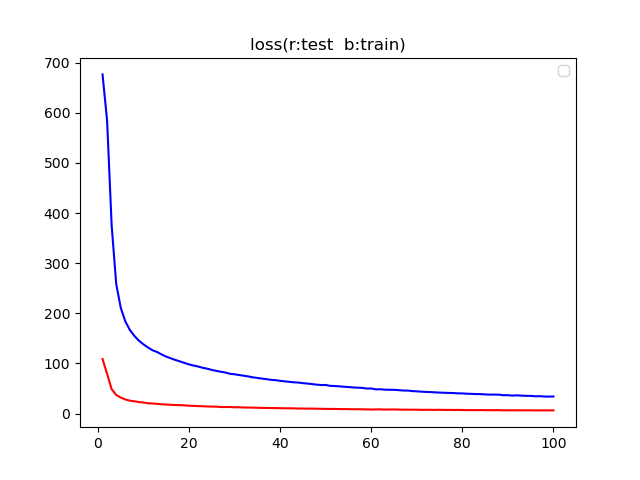

In [16]:
auto img3 = im::image("./loss_3_seq.png");
img3